In [1]:
from pylab import *
from scipy.spatial import distance
from scipy.ndimage import interpolation
import tables
import random as pyrandom

In [2]:
with tables.openFile("mnist.h5","r") as mnist:
    images = array(mnist.root.deskewed,'f')
    labels = array(mnist.root.labels,'i')
    test_images = array(mnist.root.test_deskewed,'f')
    test_labels = array(mnist.root.test_labels,'i')

In [3]:
def showgrid(images,rows=None,cols=10,size=1):
    if rows is None: rows = (len(images)+cols-1)//cols
    figsize(cols*size,rows*size)
    for i in range(len(images)):
        subplot(rows,cols,i+1)
        imshow(images[i])

The k-Means Algorithm
=====================

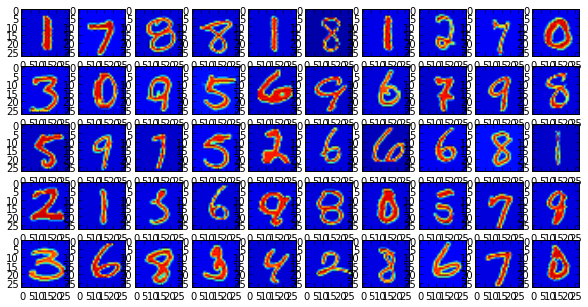

In [4]:
protos = array(pyrandom.sample(images,50),'f')
showgrid(protos)

In [5]:
from scipy.spatial.distance import cdist
def make2d(a): return a.reshape(len(a),prod(a.shape[1:]))
closest = argmin(cdist(make2d(protos),make2d(images)),axis=0)
for i in range(len(protos)):
    protos[i,:] = average(images[closest==i,:],axis=0)

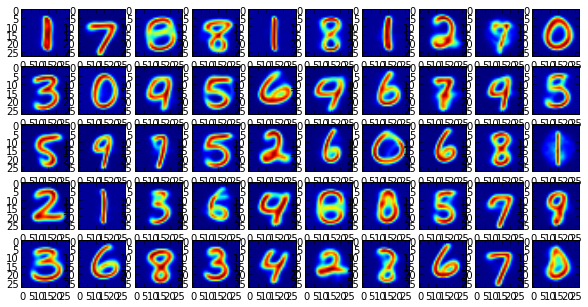

In [6]:
showgrid(protos)

In [7]:
def kmeans(images,k=50,protos=None,maxrounds=50,verbose=1):
    last_closest = -ones(len(images))
    if protos is None: protos = array(pyrandom.sample(images,k))
    for round in range(maxrounds):
        dists = cdist(make2d(protos),make2d(images))
        distortion = sum(amin(dists,axis=0))/len(images)
        closest = argmin(dists,axis=0)
        delta = sum(closest!=last_closest)
        last_closest = closest
        if verbose: print round,delta,distortion
        if delta==0: break
        for i in range(len(protos)):
            protos[i,:] = average(images[closest==i,:],axis=0)
    return protos

In [8]:
protos = kmeans(images,protos=protos)

0 60000 4.89633096854
1 7917 4.80152271087
2 5169 4.76616597228
3 3965 4.74739624393
4 3100 4.73606869655
5 2666 4.72846797302
6 2296 4.72260930411
7 2040 4.71798355986
8 1830 4.713926274
9 1751 4.71005046462
10 1616 4.7063091299
11 1382 4.70317694431
12 1228 4.70068537836
13 1034 4.69875396393
14 954 4.69717610557
15 855 4.69589637415
16 776 4.69484689542
17 649 4.69405445444
18 567 4.69343020086
19 520 4.69297141312
20 508 4.69251434001
21 472 4.69212180104
22 443 4.69176203552
23 433 4.6914174986
24 416 4.69103357681
25 397 4.69069165281
26 401 4.69034944859
27 380 4.6900712992
28 346 4.68978428872
29 293 4.68953482214
30 280 4.68932054066
31 264 4.68913012026
32 240 4.68898832769
33 212 4.68885735153
34 217 4.68870451944
35 225 4.68856641584
36 205 4.68844243897
37 228 4.68830257083
38 205 4.68815295769
39 219 4.68801849828
40 197 4.68788090185
41 162 4.68777117098
42 155 4.68766759273
43 152 4.68758096931
44 150 4.68751857016
45 150 4.68745809549
46 150 4.68738490994
47 173 4.6873

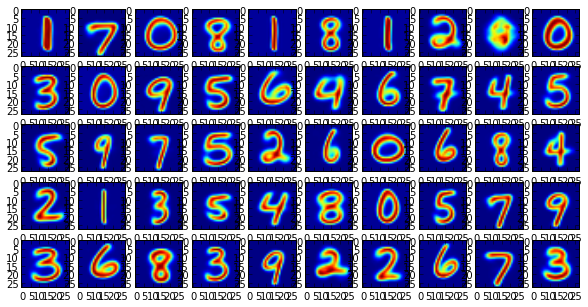

In [9]:
showgrid(protos)

k-Means as a Classifier
=======================

In [10]:
dists = cdist(make2d(protos),make2d(images))
closest = argmin(dists,axis=0)

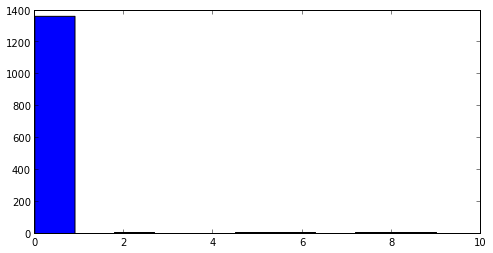

In [11]:
figsize(8,4)
_=hist(labels[closest==2])

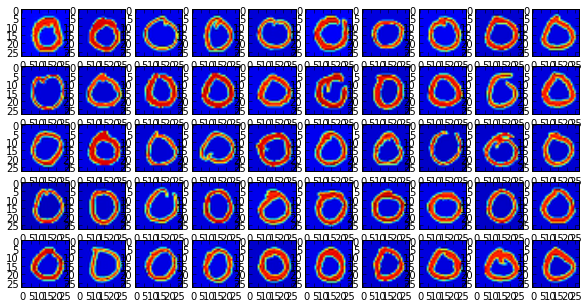

In [12]:
showgrid(images[closest==2][:50])

In [13]:
def chist(classes,n=10):
    result = zeros(n)
    for i in range(n):
        result[i] = sum(classes==i)
    return array(result,'i')

dists = cdist(make2d(protos),make2d(images))
closest = argmin(dists,axis=0)
proto_labels = [argmax(chist(labels[closest==i])) for i in range(50)]
sorted(set(proto_labels))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [14]:
def nneval(training,ltraining,testing,ltesting,metric='euclidean',p=2):
    ds = distance.cdist(make2d(testing),make2d(training),metric=metric,p=p)
    closest = argmin(ds,axis=1)
    predictions = [ltraining[i] for i in closest]
    errors = sum(array(predictions)!=array(ltesting))
    return errors*1.0/len(testing)

In [15]:
nneval(protos,proto_labels,test_images,test_labels)

0.093299999999999994

In [16]:
for k in [20,20,20,50,100,200,500]:
    protos = kmeans(images,k=k,verbose=0,maxrounds=10)
    dists = cdist(make2d(protos),make2d(images))
    closest = argmin(dists,axis=0)
    proto_labels = [argmax(chist(labels[closest==i])) for i in range(len(protos))]
    print "RESULT",k,nneval(protos,proto_labels,test_images,test_labels)

RESULT 20 0.215
RESULT 20 0.1915
RESULT 20 0.1722
RESULT 50 0.107
RESULT 100 0.0792
RESULT 200 0.0593
RESULT 500 0.0407